## 2. CUR decomposition

(145, 145, 200)


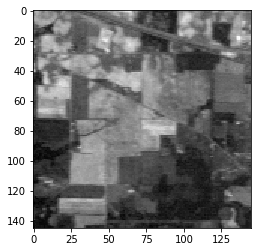

In [32]:
import numpy as np
import numpy.linalg as la
import numpy.random as rn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
#from numpy import linalg as LA

import math
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


def mpsnr(im1,im2):
    val=0
    min_value = np.zeros(im1.shape[2])
    for i in range(im1.shape[2]):
        val=val+psnr(im1[:,:,i],im2[:,:,i])
        min_value[i] = psnr(im1[:,:,i],im2[:,:,i])   
#         if psnr(im1[:,:,i],im2[:,:,i]) < min_val:
#             min_val=psnr(im1[:,:,i],im2[:,:,i])
        
    val=val/im1.shape[2]
    
    return val,min_value
    

def mnorm(im1,im2):
    val=0
    orig =0
    min_value = np.zeros(im1.shape[2])
    for i in range(im1.shape[2]):
        val=val+la.norm(im1[:,:,i]-im2[:,:,i],2)*100/la.norm(im1[:,:,i],2)
        #orig =orig+norm(im1[:,:,i])
        min_value[i] = psnr(im1[:,:,i],im2[:,:,i])   
#         if psnr(im1[:,:,i],im2[:,:,i]) < min_val:
#             min_val=psnr(im1[:,:,i],im2[:,:,i])
        
    val=val/im1.shape[2]
    
    return val,min_value    
# Reading the mat file
import scipy.io as sio

data = sio.loadmat('indian_pines_denoised.mat')
hsi = data['C_denoised']
#hsi = hsi[0:100,0:100,:]


# data = sio.loadmat('img3.mat')
# hsi = data['ref']
# hsi = hsi[100:200,100:200,:]


size = hsi.shape
print(size)
hsi_transformed = np.reshape(hsi,(size[0]*size[1], size[2])) 

plt.clf()
plt.imshow(hsi[:,:,1], cmap='gray')
plt.show()
    

In [50]:
im=hsi[:,:,1]
l=im[:,3]
# l=np.reshape(im.shape,(10000,1))
max(l)

0.0008697642481116961

In [20]:
def CUR_decomp(X, s, r):
    # Solve CUR decomposition
    
    # First compute probability
    X_square = X**2
    prob_col = np.sum(X_square,axis=0)
    prob_row = np.sum(X_square,axis=1)
    prob_col = prob_col/ np.sum(prob_col)
    prob_row = prob_row/ np.sum(prob_row)
    prob_col_cumsum = np.cumsum(prob_col)
    prob_row_cumsum = np.cumsum(prob_row)
    #print(prob_row_cumsum)
    
    
    # Second sample R and C
    id_col = np.zeros(s, np.int)
    id_row = np.zeros(r, np.int)
    
    for i in range(s):
        p = rn.rand()
        #x = np.where(prob_col_cumsum>=p)
        id_col[i] = np.where(prob_col_cumsum>=p)[0][0]
        
    id_col = np.sort(id_col)
    C = X[:,id_col]/np.sqrt(s * prob_col[None,id_col])
    
    for i in range(r):
        p = rn.rand()
        id_row[i] = np.where(prob_row_cumsum>=p)[0][0]
    id_row = np.sort(id_row)
    R = X[id_row,:]/np.sqrt(r * prob_row[id_row,None])
    
    # Solve U = C^(-1)*X*R^(-1)
    U = la.pinv(C) @ X @ la.pinv(R)
    return C, U, R



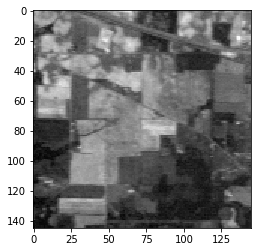

259.5978835737989
1.0455605090628395e-12


In [33]:
C, U, R = CUR_decomp(hsi_transformed, 50, 10)
hsi_cur = C @ U @ R
hsi_rest = np.reshape(hsi_cur,(size[0],size[1], size[2]))
plt.clf()
plt.imshow(hsi_rest[:,:,1], cmap='gray')
plt.show()
sio.savemat('cur_decomp.mat', {'hsi_rest':hsi_rest})

d,min_d =mpsnr(hsi,hsi_rest)
print(d)
#print(min_d)

d,min_d =mnorm(hsi,hsi_rest)
print(d)
#print(min_d)

In [9]:
#block_size = 10

def block_hsi(hsi,block_size):
    size=hsi.shape
    hsi_transformed = np.reshape(hsi,(size[0]*size[1], size[2])) 
    nrow=int(size[0]/block_size)
    ncol=int(size[1]/block_size)
    count=0
    for i in range(1,nrow+1):
        for j in range(1,ncol+1):
            block=hsi[0+(i-1)*(block_size):(i)*(block_size),0+(j-1)*(block_size):(j)*(block_size),:]
            count=count+1
            hsi_transformed[0+(count-1)*block_size*block_size:(count)*block_size*block_size,:]=np.reshape(block,(block_size*block_size, size[2]))
    

    return hsi_transformed




In [10]:

def deblock_hsi(hsi,hsi_transformed,block_size):
    size=hsi.shape
    #hsi_transformed = np.reshape(hsi,(size[0]*size[1], size[2])) 
    nrow=int(size[0]/block_size)
    ncol=int(size[1]/block_size)
    count=0
    for i in range(1,nrow+1):
        for j in range(1,ncol+1):
            count = count+1
            block = hsi_transformed[0+(count-1)*block_size*block_size:(count)*block_size*block_size,:]
            block = np.reshape(block,(block_size,block_size, size[2]))    
            hsi[0+(i-1)*(block_size):(i)*(block_size),0+(j-1)*(block_size):(j)*(block_size),:]=block
            
    return hsi

The block size is  5  and mpsnr  100.0


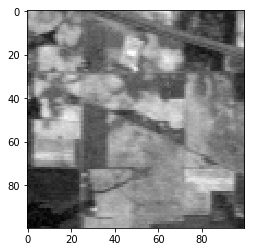

The block size is  10  and mpsnr  100.0


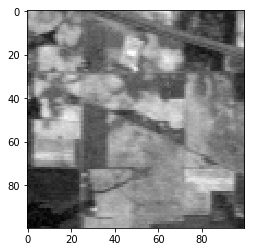

The block size is  20  and mpsnr  100.0


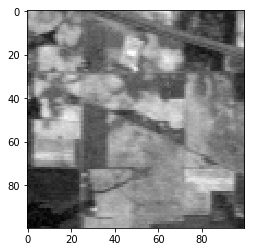

The block size is  50  and mpsnr  100.0


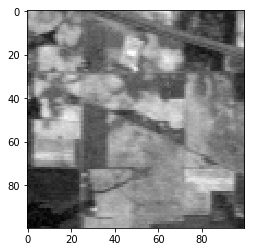

In [12]:
x= [5, 10, 20, 50]
for i in x:
    block_size = i
    hsi_transformed = block_hsi(hsi,block_size)
    C, U, R = CUR_decomp(hsi_transformed, 500, 10)
    hsi_cur = C @ U @ R
#hsi_rest = np.reshape(hsi_cur,(size[0],size[1], size[2]))
    hsi_rest = deblock_hsi(hsi,hsi_cur,block_size)
    d=mpsnr(hsi_rest,hsi)
    print("The block size is ",i," and mpsnr ",d)
    plt.clf()
    plt.imshow(hsi_rest[:,:,1], cmap='gray')
    plt.show()

sio.savemat('cur_decomp.mat', {'hsi_rest':hsi_rest})


In [5]:
def CUR_decomp_primitive(X, s, r):
    # Solve CUR decomposition
    
    # First compute probability
    X_square = X**2
    prob_col = np.sum(X_square,axis=0)
    prob_row = np.sum(X_square,axis=1)
    prob_col = prob_col/ np.sum(prob_col)
    prob_row = prob_row/ np.sum(prob_row)
    prob_col_cumsum = np.cumsum(prob_col)
    prob_row_cumsum = np.cumsum(prob_row)
    
    # Second sample R and C
    id_col = np.zeros(s, np.int)
    id_row = np.zeros(r, np.int)
    
    for i in range(s):
        p = rn.rand()
        id_col[i] = np.where(prob_col_cumsum>=p)[0][0]
    id_col = np.sort(id_col)
    C = X[:,id_col]/np.sqrt(s * prob_col[None,id_col])
    
    for i in range(r):
        p = rn.rand()
        id_row[i] = np.where(prob_row_cumsum>=p)[0][0]
    id_row = np.sort(id_row)
    R = X[id_row,:]/np.sqrt(r * prob_row[id_row,None])
    
    Psi = R[:,id_col].T/np.sqrt(s * prob_row[id_col,None])
    k = min(np.linalg.matrix_rank(R @ R.T,tol=1e-3),r)
    u, s, vt =  np.linalg.svd(R @ R.T)
    sinv =np.zeros(s.shape)
    idx = np.argsort(s)[::-1]
    for i in range(k):
        if s[idx[i]]<1e-3:
            sinv[idx[i]]=0
        else:
            sinv[idx[i]]=1.0/s[idx[i]]
    RRTinv = u @ np.diag(sinv) @ vt
    U = Psi @ RRTinv
    return C, U, R


In [6]:
C, U, R = CUR_decomp_primitive(gray_img, 100, 100)
plt.clf()
plt.imshow(C @ U @ R, cmap='gray')
plt.show()


print("L2_norm error {}%".format(la.norm(gray_img -( C @ U @ R),2)/la.norm(gray_img,2)*100))
print("Nuclear_norm error {}%".format(la.norm(gray_img - (C @ U @ R),'nuc')/la.norm(gray_img,'nuc')*100))
print("Frobenius_norm error {}%".format(la.norm(gray_img - (C @ U @ R),'fro')/la.norm(gray_img,'fro')*100))

IndexError: index 529 is out of bounds for axis 0 with size 522

In [7]:

def CUR_decomp_primitive_column(X, s, r):
    # Solve CUR decomposition
    
    # First compute probability
    X_square = X**2
    prob_col = np.sum(X_square,axis=0)
    prob_row = np.sum(X_square,axis=1)
    prob_col = prob_col/ np.sum(prob_col)
    prob_row = prob_row/ np.sum(prob_row)
    prob_col_cumsum = np.cumsum(prob_col)
    prob_row_cumsum = np.cumsum(prob_row)
    
    
    # Second sample R and C
    id_col = np.zeros(s, np.int)
    id_row = np.zeros(r, np.int)
    
    for i in range(s):
        p = rn.rand()
        id_col[i] = np.where(prob_col_cumsum>=p)[0][0]
    id_col = np.sort(id_col)
    C = X[:,id_col]/np.sqrt(s * prob_col[None,id_col])
    
    for i in range(r):
        p = rn.rand()
        id_row[i] = np.where(prob_row_cumsum>=p)[0][0]
    id_row = np.sort(id_row)
    R = X[id_row,:]/np.sqrt(r * prob_row[id_row,None])
    
    Psi =C[id_row,:].T/np.sqrt(r * prob_row[None, id_row])
    k = min(np.linalg.matrix_rank(C.T @ C,tol=1e-3),r)
    u, s, vt =  np.linalg.svd(C.T @ C)
    sinv =np.zeros(s.shape)
    idx = np.argsort(s)[::-1]
    for i in range(k):
        if s[idx[i]]<1e-3:
            sinv[idx[i]]=0
        else:
            sinv[idx[i]]=1.0/s[idx[i]]
    CTCinv = u @ np.diag(sinv) @ vt

    U = CTCinv @ Psi
    return C, U, R

0.35074499999999986


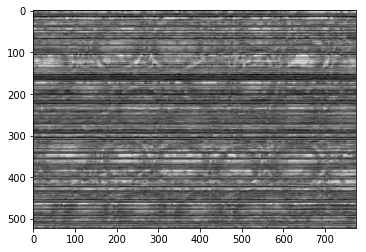

6.354036622314261
L2_norm error 88.02165544656984%
Nuclear_norm error 90.90798718426285%
Frobenius_norm error 88.88941704600623%


In [24]:
import time
start = time.clock()
C, U, R = CUR_decomp_primitive_column(gray_img, 100, 100)   
print(time.clock() - start)
#C, U, R = CUR_decomp_primitive_column(gray_img, 100, 100)
plt.clf()
plt.imshow(C @ U @ R, cmap='gray')
plt.show()


d=psnr(gray_img,C@U@R)
print(d)


print("L2_norm error {}%".format(la.norm(gray_img -( C @ U @ R),2)/la.norm(gray_img,2)*100))
print("Nuclear_norm error {}%".format(la.norm(gray_img - (C @ U @ R),'nuc')/la.norm(gray_img,'nuc')*100))
print("Frobenius_norm error {}%".format(la.norm(gray_img - (C @ U @ R),'fro')/la.norm(gray_img,'fro')*100))


In [22]:
k=100
u, s, vt =  np.linalg.svd(gray_img)

rankk = u[:,:k]@np.diag(s[:k])@vt[:k,:]    

#print("L2_norm of image {}".format(la.norm(gray_img,2)))

print("L2_norm error {}".format(la.norm(gray_img -(rankk),2)))
print("Nuclear_norm error {}".format(la.norm(gray_img - (rankk),'nuc')))
print("Frobenius_norm error {}".format(la.norm(gray_img - (rankk),'fro')))


L2_norm error 787.9200689021585
Nuclear_norm error 72882.08956844146
Frobenius_norm error 5087.965549606476


In [9]:
def CUR_decomp_primitive_column_2(X, s, r):
    # Solve CUR decomposition
    
    # First compute probability
    X_square = X**2
    prob_col = np.sum(X_square,axis=0)
    prob_row = np.sum(X_square,axis=1)
    prob_col = prob_col/ np.sum(prob_col)
    prob_row = prob_row/ np.sum(prob_row)
    prob_col_2 = prob_col
    prob_row_2 = prob_row
    
    prob_col_cumsum = np.cumsum(prob_col)
    prob_row_cumsum = np.cumsum(prob_row)
    
    
    # Second sample R and C
    id_col = np.zeros(s, np.int)
    id_row = np.zeros(r, np.int)
    
    for i in range(s):
        p = rn.rand()
        ind = np.where(prob_col_cumsum>=p)[0][0]
        id_col[i] = int(ind)
        prob_col_2[ind]=0.0
        prob_col_cumsum = np.cumsum(prob_col_2)/np.sum(prob_col_2)
        
    id_col =np.sort(id_col)
    id_col = id_col.astype(int)
    C = X[:,id_col]/np.sqrt(s * prob_col[None,id_col])
    
    for i in range(r):
        p = rn.rand()
        ind = np.where(prob_row_cumsum>=p)[0][0]
        id_row[i] = int(ind)
        prob_row_2[ind]=0.0
        prob_row_cumsum = np.cumsum(prob_row_2)/np.sum(prob_row_2)
        
    id_row =np.sort(id_row)
    id_row = id_row.astype(int)
    R = X[id_row,:]/np.sqrt(r * prob_row[id_row,None])
    
    Psi =C[id_row,:].T/np.sqrt(r * prob_row[None, id_row])
    k = min(np.linalg.matrix_rank(C.T @ C,tol=1e-3),r)
    u, s, vt =  np.linalg.svd(C.T @ C)
    sinv =np.zeros(s.shape)
    idx = np.argsort(s)[::-1]
    for i in range(k):
        if s[idx[i]]<1e-3:
            sinv[idx[i]]=0
        else:
            sinv[idx[i]]=1.0/s[idx[i]]
    CTCinv = u @ np.diag(sinv) @ vt

    U = CTCinv @ Psi
    return C, U, R

In [10]:
C, U, R = CUR_decomp_primitive_column_2(gray_img, 100, 100)
plt.clf()
plt.imshow(C @ U @ R, cmap='gray')
plt.show()


d=psnr(gray_img,C@U@R)
print(d)

print("L2_norm error {}%".format(la.norm(gray_img -( C @ U @ R),2)/la.norm(gray_img,2)*100))
print("Nuclear_norm error {}%".format(la.norm(gray_img - (C @ U @ R),'nuc')/la.norm(gray_img,'nuc')*100))
print("Frobenius_norm error {}%".format(la.norm(gray_img - (C @ U @ R),'fro')/la.norm(gray_img,'fro')*100))

/home/akshay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/akshay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/akshay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/home/akshay/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1647: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


LinAlgError: SVD did not converge

In [114]:

def CUR_lineartime(X, s, r):
    # Solve CUR decomposition
    
    # First compute probability
    X_square = X**2
    prob_col = np.sum(X_square,axis=0)
    prob_row = np.sum(X_square,axis=1)
    prob_col = prob_col/ np.sum(prob_col)
    prob_row = prob_row/ np.sum(prob_row)
    prob_col_2 = prob_col
    prob_row_2 = prob_row
    
    prob_col_cumsum = np.cumsum(prob_col)
    prob_row_cumsum = np.cumsum(prob_row)
    
    
    # Second sample R and C
    id_col = np.zeros(s, np.int)
    id_row = np.zeros(r, np.int)
    
    for i in range(s):
        p = rn.rand()
        ind = np.where(prob_col_cumsum>=p)[0][0]
        id_col[i] = int(ind)
        prob_col_2[ind]=0.0
        prob_col_cumsum = np.cumsum(prob_col_2)/np.sum(prob_col_2)
        
    id_col =np.sort(id_col)
    id_col = id_col.astype(int)
    C = X[:,id_col]/np.sqrt(s * prob_col[None,id_col])
    
    for i in range(r):
        p = rn.rand()
        ind = np.where(prob_row_cumsum>=p)[0][0]
        id_row[i] = int(ind)
        prob_row_2[ind]=0.0
        prob_row_cumsum = np.cumsum(prob_row_2)/np.sum(prob_row_2)
        
    id_row =np.sort(id_row)
    id_row = id_row.astype(int)
    R = X[id_row,:]/np.sqrt(r * prob_row[id_row,None])
    
#     for i in range(s):
#         p = rn.rand()
#         id_col[i] = np.where(prob_col_cumsum>=p)[0][0]
#     id_col = np.sort(id_col)
#     C = X[:,id_col]/np.sqrt(s * prob_col[None,id_col])
    
#     for i in range(r):
#         p = rn.rand()
#         id_row[i] = np.where(prob_row_cumsum>=p)[0][0]
#     id_row = np.sort(id_row)
#     R = X[id_row,:]/np.sqrt(r * prob_row[id_row,None])
    
    Psi =C[id_row,:]/np.sqrt(r * prob_row[None, id_row])
    
    # Rank
    k = min(np.linalg.matrix_rank(C.T @ C,tol=1e-3),r)
    
#     # For C^T.C inverse
#     u, s, vt =  np.linalg.svd(C.T @ C)
#     sinv =np.zeros(s.shape)
#     idx = np.argsort(s)[::-1]
#     for i in range(k):
#         if s[idx[i]]<1e-3:
#             sinv[idx[i]]=0
#         else:
#             sinv[idx[i]]=1.0/s[idx[i]]
#     CTCinv = vt.T @ np.diag(sinv) @ u.T
    CTCinv = np.linalg.inv(C.T@C)
    U = CTCinv @ Psi.T
    return C, U, R


/home/akshay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/home/akshay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/home/akshay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/home/akshay/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1647: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
/home/akshay/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/akshay/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/akshay/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:412: UserWarnin

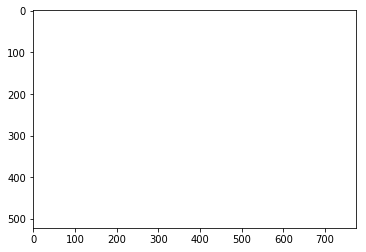

nan
L2_norm error nan%
Nuclear_norm error nan%
Frobenius_norm error nan%


In [115]:
C, U, R = CUR_lineartime(gray_img, 100, 100)
plt.clf()
plt.imshow(C @ U @ R, cmap='gray')
plt.show()


d=psnr(gray_img,C@U@R)
print(d)

print("L2_norm error {}%".format(la.norm(gray_img -( C @ U @ R),2)/la.norm(gray_img,2)*100))
print("Nuclear_norm error {}%".format(la.norm(gray_img - (C @ U @ R),'nuc')/la.norm(gray_img,'nuc')*100))
print("Frobenius_norm error {}%".format(la.norm(gray_img - (C @ U @ R),'fro')/la.norm(gray_img,'fro')*100))

For analysis of error, you can estimate $\frac{\|A-CUR\|}{\|A\|}$ and try to let the error be less than $10\%$. Below are one specific example. Based on choice of $U$, there will be three possibilities.

In [4]:
# def columnselect(X,c,k):
#     u, s, vt =  np.linalg.svd(X)
#     v_square = (vt.T)**2
#     #prob_col = np.sum(v_square,axis=0)
#     prob_row = np.sum(v_square[:,:k],axis=1)
#     #prob_col = prob_col/ np.sum(prob_col)
#     prob_row = prob_row/k
#     #prob_col_cumsum = np.cumsum(prob_col)
#     prob_row_cumsum = np.cumsum(prob_row)
    
#     id_row = np.zeros(c, np.int)
#     for i in range(c):
#         p = rn.rand()
#         id_row[i] = np.where(prob_row_cumsum>=p)[0][0]
#     id_row = np.sort(id_row)
#     #print(id_row)
#     C = X[:,id_row] /np.sqrt(c*c* prob_row[id_row,None])      
#     return C

def columnselect(X,c,k):
    
    u, s, vt =  np.linalg.svd(X)
    v_square = (vt.T)**2
    #prob_col = np.sum(v_square,axis=0)
    prob_row = np.sum(v_square[:,:k],axis=1)/k
    prob_row_2 = prob_row
    
    prob_row_cumsum = np.cumsum(prob_row)/np.sum(prob_row)
    n,d=X.shape
    #prob_row = prob_row/k
   
    count = 0
    id_row = np.ones(c)*c
    #id_row = np.zeros(c, np.int)
#     for i in range(c):
        
#         p = rn.rand()
#         a=min(1,prob_row[i])
#         if count == c:
#             print()
#             exit
#         elif a>p:
#             count+= 1
#             id_row[count] = i
#         else:
#             pass
    for i in range(c):
        p = rn.rand()
        ind = np.where(prob_row_cumsum>=p)[0][0]
        id_row[i] = int(ind)
        prob_row_2[ind]=0.0
        prob_row_cumsum = np.cumsum(prob_row_2)/np.sum(prob_row_2)
        
    id_row =np.sort(id_row)
    id_row = id_row.astype(int)
    #
    #print(id_row)
    #print(prob_row.shape)
    #print(d)
    C = np.zeros((n,c),np.float)
    for i in range(c):
        ind=id_row[i]
        #print(ind)
        C[:,i] = X[:,ind] #/np.sqrt(c*c* prob_row[id_row[i],None])      
        
    return C



def CUR_leveragescore(X,c,r):
    k = min(np.linalg.matrix_rank(X,tol=1e-3),c,r) 
    print(k)
    C = columnselect(X,c,k)  
    print(C.shape)
    R = columnselect(X.T,r,k)
    #print(R.shape)
    R = R.T
    U = la.pinv(C) @ X @ la.pinv(R)
    return C,U,R




In [5]:
C, U, R = CUR_leveragescore(hsi_transformed, 1000, 20)
hsi_cur = C @ U @ R
hsi_rest = np.reshape(hsi_cur,(size[0],size[1], size[2]))
plt.clf()
plt.imshow(hsi_rest[:,:,1], cmap='gray')
plt.show()
sio.savemat('cur_leverage.mat', {'hsi_rest':hsi_rest})

6


/home/akshay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/home/akshay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater_equal


IndexError: index 0 is out of bounds for axis 0 with size 0

For block CUR decomposition. You can try either sample in group or sample in each block. Here is one example of sample in block

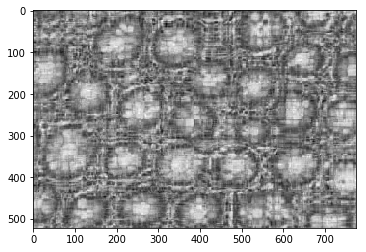

L2_norm error 4.871129554018044%
Nuclear_norm error 59.93626451668366%
Frobenius_norm error 20.983886433307436%
18.893319239798384


In [90]:
# block_img = np.zeros(gray_img.shape)

# # 8 by 8 blocks with each block 64*64
# for i in range(8):
#     for j in range(10):
#         part = gray_img[i*64:(i+1)*64,j*64:(j+1)*64]
#         C, U, R = CUR_decomp(part, 12, 12)
#         block_img[i*64:(i+1)*64,j*64:(j+1)*64] = C@U@R
        
# plt.clf()
# plt.imshow(block_img, cmap='gray')
# plt.show()


# print("L2_norm error {}%".format(la.norm(gray_img -( block_img),2)/la.norm(gray_img,2)*100))
# print("Nuclear_norm error {}%".format(la.norm(gray_img - (block_img),'nuc')/la.norm(gray_img,'nuc')*100))
# print("Frobenius_norm error {}%".format(la.norm(gray_img - (block_img),'fro')/la.norm(gray_img,'fro')*100))

block_img = np.zeros(gray_img.shape)

# 6 by 6 blocks with each block 87*129
for i in range(6):
    for j in range(6):
        part = gray_img[i*87:(i+1)*87,j*129:(j+1)*129]
        C, U, R = CUR_decomp(part, 12, 12)
        block_img[i*87:(i+1)*87,j*129:(j+1)*129] = C@U@R
        
plt.clf()
plt.imshow(block_img, cmap='gray')
plt.show()


print("L2_norm error {}%".format(la.norm(gray_img -( block_img),2)/la.norm(gray_img,2)*100))
print("Nuclear_norm error {}%".format(la.norm(gray_img - (block_img),'nuc')/la.norm(gray_img,'nuc')*100))
print("Frobenius_norm error {}%".format(la.norm(gray_img - (block_img),'fro')/la.norm(gray_img,'fro')*100))

d=psnr(gray_img,block_img)
print(d)


In [34]:
import math
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(gray_img,block_img)
print(d)

19.01683485425519


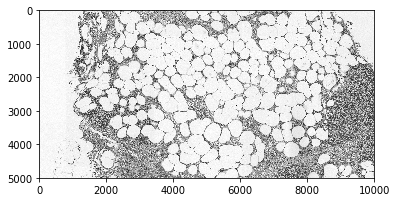

In [40]:
#img = plt.imread("test_image.png")
img = mpimg.imread("Output.jpg")
gray_img = rgb2gray(img)   
#plt.clf
imgplot = plt.imshow(gray_img,cmap='gray')
plt.show()

In [41]:
gray_img.shape

(5000, 10000)

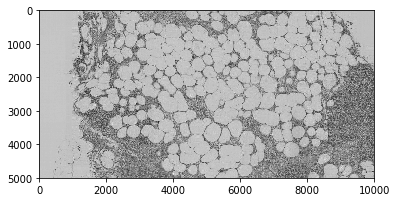

22.97322269336675
L2_norm error 0.5864106815066605%
Nuclear_norm error 51.196954958313654%
Frobenius_norm error 8.446171439043082%


In [42]:

block_img = np.zeros(gray_img.shape)

# 6 by 6 blocks with each block 500*500
for i in range(10):
    for j in range(20):
        part = gray_img[i*500:(i+1)*500,j*500:(j+1)*500]
        C, U, R = CUR_leveragescore(part, 50, 50)
        block_img[i*500:(i+1)*500,j*500:(j+1)*500] = C@U@R
        
plt.clf()
plt.imshow(block_img, cmap='gray')
plt.show()

d=psnr(gray_img,block_img)
print(d)

print("L2_norm error {}%".format(la.norm(gray_img -( block_img),2)/la.norm(gray_img,2)*100))
print("Nuclear_norm error {}%".format(la.norm(gray_img - (block_img),'nuc')/la.norm(gray_img,'nuc')*100))
print("Frobenius_norm error {}%".format(la.norm(gray_img - (block_img),'fro')/la.norm(gray_img,'fro')*100))